# Batch Normalization Activity 9 Chapter 4 

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
transform = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(0.5), 
        transforms.RandomGrayscale(0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [3]:
batch_size = 100

train_data = datasets.CIFAR10('data2', train=True, download=True, transform=transform["train"])
test_data = datasets.CIFAR10('data2', train=False, download=True, transform=transform["test"])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(dev_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Batch Normalization
## Problem Statement
Input images often have values that come from different scales or distributions. This can negatively impact performance since images of the same object, maybe an animal, can have different colors or distributions of color causing models to perform poorly. 
## Solution Statement
By normalizing values coming from the input layer and also the outputs of hidden layers, we can reduce variance and make more even level comparisons. Other benefits include:
- Since outputs values are being controlled we can take advantage of higher learning rates.
- This helps reduce overfitting since it has a regularization effect meaning we can reduce our dropout probability and not ignore information from pass to pass.

## Questions
- What is the difference between BatchNorm1d and 2d?
  - 1D takes input data over 2 or 3 dimensions, also stated as a mini-batch of 1D input with and optional additional channel dimension. So NxCxW (N: batch size, C: number of channels, W: width of 1D data)
  - 2D takes input data over 4D inputs, also stated as a mini-batch of 2D input with an additional channel dimension. So NxCxWxH (N: batch size, C: number of channels, W: width of 2D data, H: height of 2D data)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(40)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(40 * 4 * 4, 100)
        self.norm4 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.norm1(F.relu(self.conv1(x))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = self.pool(self.norm3(F.relu(self.conv3(x))))
        
        x = x.view(-1, 40 * 4 * 4)
        x = self.dropout(x)
        x = self.norm4(F.relu(self.linear1(x)))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

In [7]:
model = CNN()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [8]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1

        pred = model(data)
        loss = loss_function(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target, top_class)
        
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
        
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        with torch.no_grad():
            model.eval()
            
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                
                dev_pred = model(data_dev)
                dev_loss = loss_function(dev_pred, target_dev)
                dev_losss += dev_loss.item()

                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev, dev_top_class)
        
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(losses/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}.. ".format(acc/iterations),
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

Epoch: 1/100..  Training Loss: 1.456..  Validation Loss: 1.168..  Training Accuracy: 0.477..  Validation Accuracy: 0.584
Epoch: 5/100..  Training Loss: 0.920..  Validation Loss: 0.886..  Training Accuracy: 0.678..  Validation Accuracy: 0.685
Epoch: 10/100..  Training Loss: 0.787..  Validation Loss: 0.780..  Training Accuracy: 0.722..  Validation Accuracy: 0.728
Epoch: 15/100..  Training Loss: 0.725..  Validation Loss: 0.721..  Training Accuracy: 0.746..  Validation Accuracy: 0.746
Epoch: 20/100..  Training Loss: 0.688..  Validation Loss: 0.712..  Training Accuracy: 0.761..  Validation Accuracy: 0.752
Epoch: 25/100..  Training Loss: 0.660..  Validation Loss: 0.663..  Training Accuracy: 0.767..  Validation Accuracy: 0.770
Epoch: 30/100..  Training Loss: 0.632..  Validation Loss: 0.655..  Training Accuracy: 0.779..  Validation Accuracy: 0.771
Epoch: 35/100..  Training Loss: 0.615..  Validation Loss: 0.671..  Training Accuracy: 0.782..  Validation Accuracy: 0.763
Epoch: 40/100..  Training 

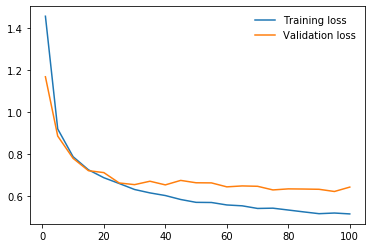

In [9]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

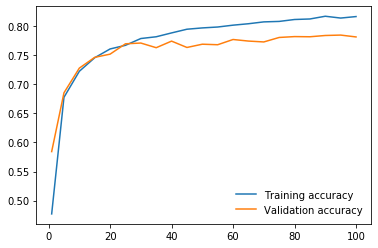

In [10]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [11]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test)
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test, top_class_test)
print(acc_test/iter_3)

0.7805999999999998
